In [1]:
!pip install -q transformers datasets torch scikit-learn matplotlib seaborn pandas numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency 

In [1]:
import os
import json
import pandas as pd
import numpy as np
import csv
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)
os.makedirs("results/csv", exist_ok=True)

In [3]:
def load_json_lines(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

# Load raw dataset
raw_data = load_json_lines("/kaggle/input/amazon-electronics-reviews/Electronics_5.json")

# Extract relevant columns: reviewText, overall (rating), summary for sentiment classification
df = pd.DataFrame(raw_data)[['reviewText', 'overall', 'summary']]

# Filter out rows where reviewText or overall is null, very short reviews etc.
df = df[df['reviewText'].notna()]
df = df[df['overall'].notna()]

# Convert overall ratings into 3 classes: Negative (1-2), Neutral (3), Positive (4-5)
def sentiment_label(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['sentiment'] = df['overall'].apply(sentiment_label)

# Drop unnecessary columns, keep reviewText and new sentiment
df = df[['reviewText', 'sentiment']].reset_index(drop=True)

print(f"Dataset size after filtering: {df.shape[0]} samples")
print(df['sentiment'].value_counts())

# Save a sample for quick inspection
df.head()

Dataset size after filtering: 1689188 samples
sentiment
2    1356067
0     190864
1     142257
Name: count, dtype: int64


,reviewText,sentiment
0,We got this GPS for my husband who is an (OTR)...,2
1,"I'm a professional OTR truck driver, and I bou...",0
2,"Well, what can I say. I've had this unit in m...",1
3,"Not going to write a long review, even thought...",0
4,I've had mine for a year and here's what we go...,0


In [4]:
train_val, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['sentiment'])
train, val = train_test_split(train_val, test_size=0.1, random_state=42, stratify=train_val['sentiment'])

print(f"Train size: {train.shape[0]}")
print(f"Validation size: {val.shape[0]}")
print(f"Test size: {test.shape[0]}")

# Save splits
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('test.csv', index=False)

Train size: 1368242
Validation size: 152027
Test size: 168919


In [5]:
# Desired total training size after subsampling
desired_train_size = 50000

# Current train size
current_train_size = train.shape[0]

# Calculate fraction to sample from training data
train_frac = desired_train_size / current_train_size

# Stratified subsample of training set
train_sub = train.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(frac=train_frac, random_state=42))

print("Subsample train sentiment distribution:")
print(train_sub['sentiment'].value_counts(normalize=True))

# Subsample test set to 5000 samples proportionally
desired_test_size = 5000
test_frac = desired_test_size / test.shape[0]

test_sub = test.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(frac=test_frac, random_state=42))

print("Subsample test sentiment distribution:")
print(test_sub['sentiment'].value_counts(normalize=True))

# Save subsampled sets
train_sub.to_csv('train_subsampled.csv', index=False)
val.to_csv('val.csv', index=False)  # Validation data unchanged
test_sub.to_csv('test_subsampled.csv', index=False)

# Replace train and test DataFrames with the subsampled versions and reset index
train = train_sub.reset_index(drop=True)
test = test_sub.reset_index(drop=True)
val = val.reset_index(drop=True)  # Also reset validation index for consistency

/tmp/ipykernel_36/3890912235.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_sub = train.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(frac=train_frac, random_state=42))
/tmp/ipykernel_36/3890912235.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_sub = test.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(frac=test_frac, random_state=42))


Subsample train sentiment distribution:
sentiment
2    0.802784
0    0.112998
1    0.084218
Name: proportion, dtype: float64
Subsample test sentiment distribution:
sentiment
2    0.8028
0    0.1130
1    0.0842
Name: proportion, dtype: float64


In [6]:
class AmazonReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=160):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        review = str(self.data.iloc[idx]['reviewText'])
        label = self.data.iloc[idx]['sentiment']
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_dataset = AmazonReviewDataset(train, tokenizer)
val_dataset = AmazonReviewDataset(val, tokenizer)
test_dataset = AmazonReviewDataset(test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # 3 sentiment classes
)
model.to(device)

2025-09-06 13:01:19.079163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757163679.233235      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757163679.278985      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [9]:
from transformers import get_linear_schedule_with_warmup

EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_preds = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        correct_preds += torch.sum(preds == labels)
    
    return correct_preds.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model.eval()
    losses = []
    correct_preds = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            
            losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            correct_preds += torch.sum(preds == labels)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct_preds.double() / len(data_loader.dataset)
    avg_loss = np.mean(losses)
    return accuracy, avg_loss, all_preds, all_labels

In [11]:
history = {
    'epoch': [],
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': [],
    'f1': [],
    'precision': [],
    'recall': []
}

best_f1 = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    val_acc, val_loss, val_preds, val_labels = eval_model(model, val_loader, criterion, device)
    
    # Calculate classification metrics for validation
    report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)
    f1 = report['weighted avg']['f1-score']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    
    print(f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
    print(f"Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Val F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Save best model checkpoint
    if f1 > best_f1:
        best_f1 = f1
        checkpoint_path = f"checkpoints/best_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved best model checkpoint to {checkpoint_path}")
    
    # Log history for each epoch
    history['epoch'].append(epoch+1)
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    history['f1'].append(f1)
    history['precision'].append(precision)
    history['recall'].append(recall)

# Save history to CSV
hist_df = pd.DataFrame(history)
hist_df.to_csv('results/csv/training_history.csv', index=False)

Epoch 1/4


Validation: 100%|██████████| 4751/4751 [06:08<00:00, 12.89it/s]


Train Acc: 0.8359, Train Loss: 0.4376
Val Acc: 0.8758, Val Loss: 0.3330
Val F1: 0.8549, Precision: 0.8512, Recall: 0.8758
Saved best model checkpoint to checkpoints/best_model_epoch_1.pth
Epoch 2/4


Validation: 100%|██████████| 4751/4751 [06:09<00:00, 12.84it/s]


Train Acc: 0.8935, Train Loss: 0.2884
Val Acc: 0.8802, Val Loss: 0.3213
Val F1: 0.8683, Precision: 0.8624, Recall: 0.8802
Saved best model checkpoint to checkpoints/best_model_epoch_2.pth
Epoch 3/4


Validation: 100%|██████████| 4751/4751 [06:09<00:00, 12.85it/s]


Train Acc: 0.9226, Train Loss: 0.2113
Val Acc: 0.8748, Val Loss: 0.3627
Val F1: 0.8706, Precision: 0.8671, Recall: 0.8748
Saved best model checkpoint to checkpoints/best_model_epoch_3.pth
Epoch 4/4


Validation: 100%|██████████| 4751/4751 [06:10<00:00, 12.83it/s]


Train Acc: 0.9460, Train Loss: 0.1529
Val Acc: 0.8732, Val Loss: 0.3959
Val F1: 0.8702, Precision: 0.8677, Recall: 0.8732


Validation: 100%|██████████| 157/157 [00:12<00:00, 12.79it/s]


Test Accuracy: 0.8734
Test Loss: 0.3706
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       565
           1       0.42      0.35      0.38       421
           2       0.93      0.95      0.94      4014

    accuracy                           0.87      5000
   macro avg       0.69      0.67      0.68      5000
weighted avg       0.87      0.87      0.87      5000



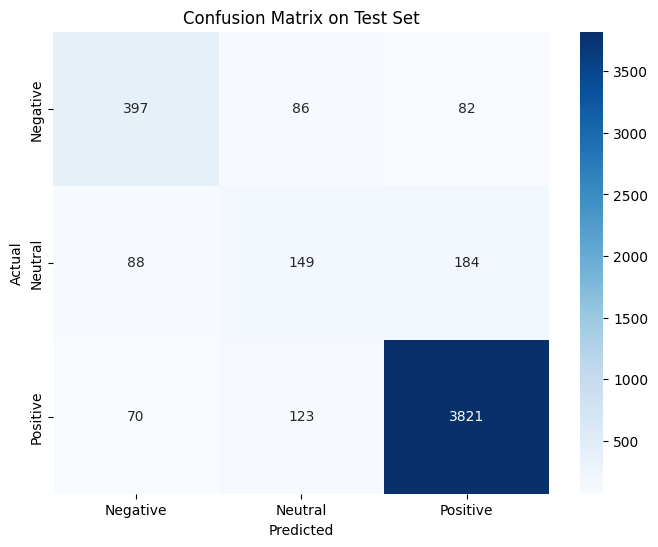

In [12]:
best_checkpoint = sorted(os.listdir('checkpoints'), key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1]
model.load_state_dict(torch.load(f"checkpoints/{best_checkpoint}"))
model.eval()

test_acc, test_loss, test_preds, test_labels = eval_model(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

print("Classification Report on Test Set:")
print(classification_report(test_labels, test_preds, zero_division=0))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Neutral','Positive'], yticklabels=['Negative','Neutral','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.savefig('results/plots/test_confusion_matrix.png')
plt.show()

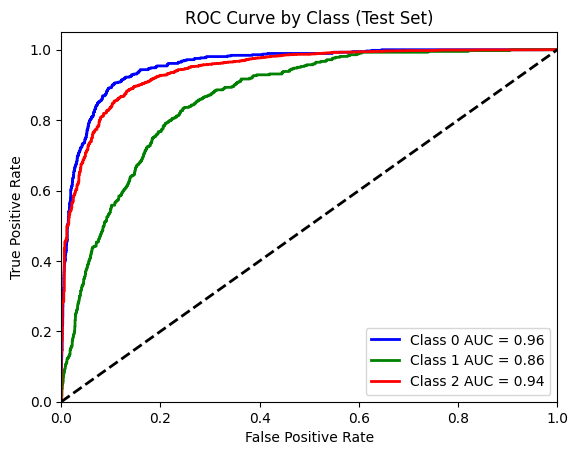

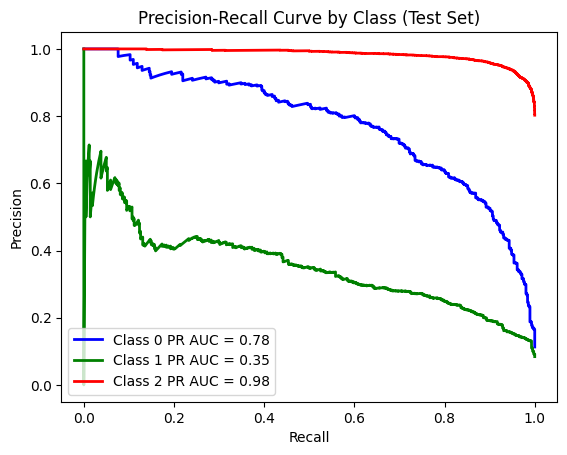

In [13]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

test_labels_bin = label_binarize(test_labels, classes=[0,1,2])

def get_probs(model, data_loader, device):
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            prob = torch.nn.functional.softmax(outputs.logits, dim=1)
            probs.append(prob.cpu().numpy())
    return np.vstack(probs)

test_probs = get_probs(model, test_loader, device)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class (Test Set)')
plt.legend(loc="lower right")
plt.savefig('results/plots/test_roc_curve.png')
plt.show()

precision = dict()
recall = dict()
pr_auc = dict()
from sklearn.metrics import precision_recall_curve
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], test_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure()
for i, color in zip(range(3), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {i} PR AUC = {pr_auc[i]:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve by Class (Test Set)')
plt.legend(loc="lower left")
plt.savefig('results/plots/test_pr_curve.png')
plt.show()

In [14]:
test_results_df = pd.DataFrame({
    'reviewText': test['reviewText'].values,
    'true_label': test_labels,
    'pred_label': test_preds,
    'prob_negative': test_probs[:,0],
    'prob_neutral': test_probs[:,1],
    'prob_positive': test_probs[:,2],
})

test_results_df.to_csv('results/csv/test_predictions.csv', index=False)

In [15]:
import shutil

# Define the source directory and the output zip file name
source_dir = '/kaggle/working/results'
output_filename = '/kaggle/working/results_zipped'

# Create the zip file
shutil.make_archive(output_filename, 'zip', source_dir)

print("ZIP file created successfully.")

ZIP file created successfully.
